<a href="https://colab.research.google.com/github/pranath/flower_recognition/blob/master/image_classifier_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an AI application to recognise flower species
# Part 4

## Introduction

In an [earlier project](https://github.com/pranath/flower_recognition/blob/master/image_classifier.ipynb) I developed a deep learning image classifier to classify images of 102 categories of flower species from the Oxford visual geometry group. The deep learning library used for that project was PyTorch, and the best result achieved in that project was a test accuracy of 73%.

In the [next project](https://github.com/pranath/flower_recognition/blob/master/image_classifier-v2.ipynb), I looked at the same dataset, but used a new deep learning library called [fastai](https://www.fast.ai) (which is based on PyTorch) to develop an image classifier, and achieved a test accuracy of 93%.

In this project, I will again look at the same dataset and apply the latest version of Fastai's library - version 2.

## Import libraries & config

In [95]:
!pip install fastai --upgrade -q # Upgrade to fastai v2
import fastai
from fastai.vision.all import *
from fastai.callback.fp16 import *
from fastai.metrics import error_rate
from PIL import Image

%reload_ext autoreload
%autoreload 2
%matplotlib inline

fastai.__version__

'2.2.7'

## Load data

In [96]:
path = untar_data(URLs.FLOWERS)
Path.BASE_PATH = path
path.ls()

(#4) [Path('test.txt'),Path('jpg'),Path('train.txt'),Path('valid.txt')]

In [97]:
train_df = pd.read_csv(path/'train.txt',header=None,sep=' ')
train_df['is_valid'] = 0
train_df.head()

,0,1,is_valid
0,jpg/image_03860.jpg,16,0
1,jpg/image_06092.jpg,13,0
2,jpg/image_02400.jpg,42,0
3,jpg/image_02852.jpg,55,0
4,jpg/image_07710.jpg,96,0


In [98]:
valid_df = pd.read_csv(path/'valid.txt',header=None,sep=' ')
valid_df['is_valid'] = 1
valid_df.head()

,0,1,is_valid
0,jpg/image_04467.jpg,89,1
1,jpg/image_07129.jpg,44,1
2,jpg/image_05166.jpg,4,1
3,jpg/image_07002.jpg,34,1
4,jpg/image_02007.jpg,79,1


In [99]:
# Merge train and validation
trainvalid_df = pd.concat([train_df, valid_df], ignore_index=True)

In [100]:
test_df = pd.read_csv(path/'test.txt',header=None,sep=' ')
test_df['is_valid'] = 1
test_df.head()

,0,1,is_valid
0,jpg/image_06977.jpg,34,1
1,jpg/image_00800.jpg,80,1
2,jpg/image_05038.jpg,58,1
3,jpg/image_06759.jpg,0,1
4,jpg/image_01133.jpg,45,1


In [101]:
# Merge train and test
traintest_df = pd.concat([train_df, test_df], ignore_index=True)

## Explore dataset

We will look at the same images from my [last study](https://github.com/pranath/flower_recognition/blob/master/image_classifier.ipynb) to validate we have the same dataset used as previously.

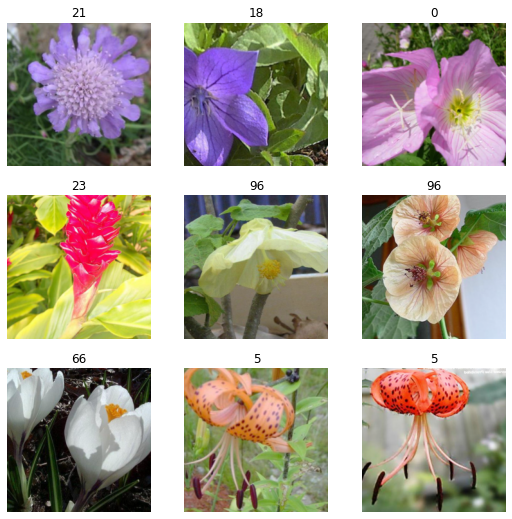

In [102]:
def get_x(r): return path/r[0]
def get_y(r): return r[1]

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=ColSplitter('is_valid'),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
                  
dls = dblock.dataloaders(trainvalid_df)
# A quick look at some of these images with handy fastai function
dls.show_batch(nrows=3, ncols=3)

## Create model using resnet34

In [103]:
# Create initial pre-trained model - resnet34
learn = cnn_learner(dls, resnet34, metrics=error_rate)
# Fine tune model: 1. Train random final layer 1 epoch 2. Unfreeze all layers & train for requested epochs
#learn.fine_tune(8, freeze_epochs=3, base_lr=3e-3)
learn.fine_tune(8, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,6.351008,4.940700,0.975490,00:21
1,5.574485,2.961922,0.652941,00:21
2,4.282710,1.549334,0.337255,00:21


epoch,train_loss,valid_loss,error_rate,time
0,1.611155,1.357114,0.285294,00:22
1,1.319266,0.943023,0.210784,00:22
2,1.048486,0.735140,0.174510,00:21
3,0.795216,0.619294,0.143137,00:21
4,0.605220,0.567201,0.134314,00:21
5,0.472927,0.529416,0.119608,00:21
6,0.382804,0.515265,0.122549,00:21
7,0.313592,0.511866,0.119608,00:21


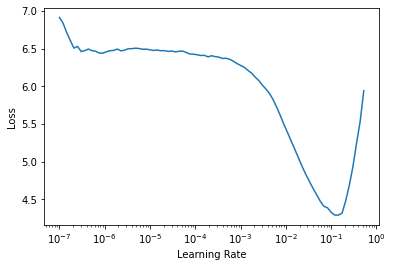

In [104]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
# Plot learning rate finder
lr_min,lr_steep = learn.lr_find()

In [105]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.45e-02, steepest point: 7.59e-03


We can see on this plot that in the range 1e-7 to 1e-3, nothing really happens and the model doesn't train. Then the loss starts to decrease until it reaches a minimum, and then increases again. We don't want a learning rate greater than 1e-1 as it will give a training that diverges, but 1e-1 is already too high: at this stage we've left the period where the loss was decreasing steadily.

In this learning rate plot it appears that a learning rate around 3e-3 would be appropriate.

We will now try to fine tune the model, a more general approach to improving the model.

However we can also use a more customised approach, using the underlying method directly 'fit one cycle'.

In [106]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,5.607511,2.623633,0.608824,00:21
1,3.559180,1.346390,0.346078,00:21
2,2.509206,1.146085,0.280392,00:21


This trains the final layer for 3 epochs. We can now unfreeze the rest of the model, and we can run the learning rate finder again as we have already trained the model and we are now training many more layers.

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=1.5848931980144698e-06)

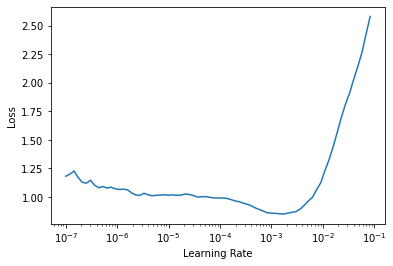

In [107]:
# Unfreeze rest of model
learn.unfreeze()
# Save model
learn.save('flowers-model-1')
# Plot learning rate finder
learn.lr_find()

The shape of the graph looks different to the previous, because the model has been trained already. We should take a point well before the sharp increase, in this case say. Lets train the model some more using this learning rate.

In [108]:
# Load previous model
learn.load('flowers-model-1')
# Fit with selected learning rate
learn.fit_one_cycle(8, lr_max=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.988562,1.052181,0.267647,00:22
1,1.028496,2.686150,0.609804,00:21
2,1.090722,2.230283,0.517647,00:22
3,0.993766,1.147253,0.304902,00:21
4,0.809710,0.710453,0.174510,00:22
5,0.625451,0.587101,0.143137,00:22
6,0.482491,0.497299,0.118627,00:22
7,0.379543,0.472452,0.117647,00:22


So the results with resnet34 are better than the previous study for resnet34 but not our best of all time - lets try some more improvements.

### Use discriminative learning rates

We can use discriminative learning rates to try to further improve the model training.

In [109]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
# Save model
learn.save('flowers-model-2')

epoch,train_loss,valid_loss,error_rate,time
0,5.480402,2.539655,0.572549,00:21
1,3.492470,1.219948,0.297059,00:21
2,2.460338,1.071358,0.244118,00:21


Path('models/flowers-model-2.pth')

In [110]:
# Load previous model
learn.load('flowers-model-2')
# Unfreeze previous layers
learn.unfreeze()
# Fit with discriminative learning rates
learn.fit_one_cycle(8, lr_max=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.984245,0.907357,0.204902,00:22
1,0.810520,0.824779,0.205882,00:22
2,0.645449,0.736297,0.178431,00:22
3,0.504503,0.517886,0.122549,00:22
4,0.392785,0.478235,0.116667,00:22
5,0.308090,0.419671,0.102941,00:22
6,0.237201,0.397423,0.093137,00:22
7,0.188290,0.398348,0.092157,00:21


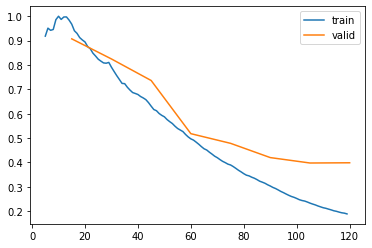

In [111]:
learn.recorder.plot_loss()

So we get to around 90% accuracy.

### Explore results

Lets examine some of the examples our model found most difficult to classify.

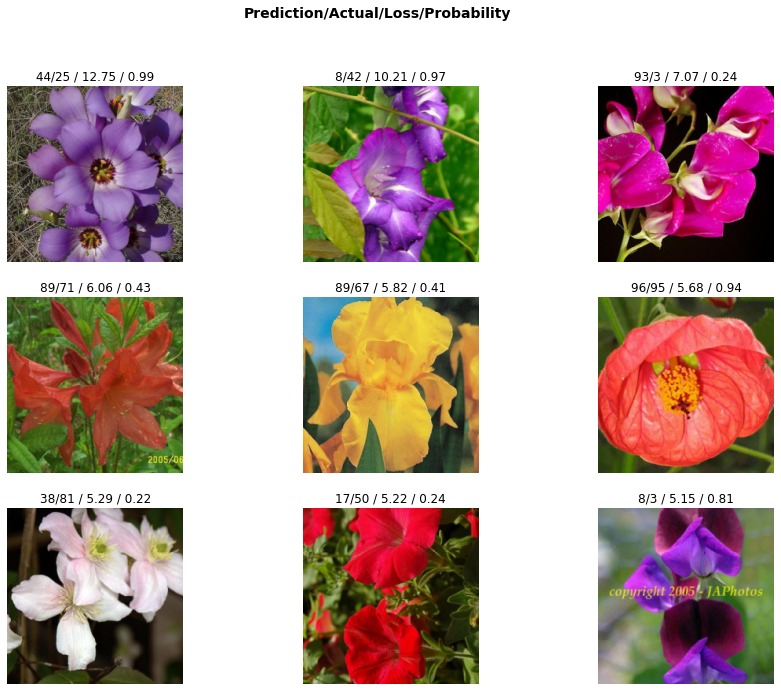

In [112]:
# Get the top losses/mis-classified
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

In [113]:
interp.most_confused(min_val=5)

[]

## Create model using resnet50

We will try creating a model with a bigger architecture, and also try using mixed-precision training.

In [114]:
# Create model & train
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
# Try fine tune first
#learn.fine_tune(6, freeze_epochs=3, base_lr=3e-3)
learn.fine_tune(8, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,6.162542,3.803881,0.813725,00:21
1,4.354911,1.340465,0.307843,00:21
2,2.920920,0.808599,0.194118,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.549985,0.690345,0.158824,00:22
1,0.435680,0.576372,0.141176,00:22
2,0.342742,0.521611,0.133333,00:22
3,0.254459,0.469021,0.120588,00:22
4,0.207385,0.437068,0.111765,00:22
5,0.158184,0.434348,0.117647,00:22
6,0.124473,0.419504,0.110784,00:22
7,0.101593,0.417221,0.109804,00:22


Now try more customised approach

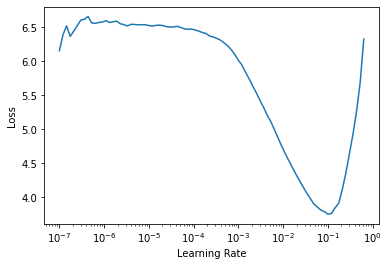

In [115]:
# Plot learning rate finder
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
lr_min,lr_steep = learn.lr_find()

In [116]:
# Now try more customised approach
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,4.658645,1.541249,0.386275,00:21
1,2.609961,0.826762,0.217647,00:21
2,1.688091,0.735519,0.195098,00:21


SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=1.0964781722577754e-06)

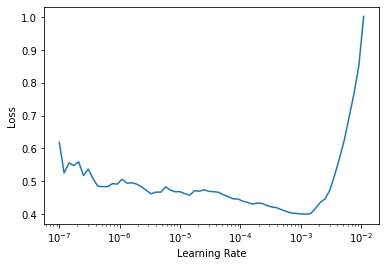

In [117]:
# Unfreeze rest of model
learn.unfreeze()
# Save model
learn.save('flowers-model-3')
# Plot learning rate finder
learn.lr_find()

In [118]:
# Load previous model
learn.load('flowers-model-3')
# Fit with selected learning rate
learn.fit_one_cycle(8, lr_max=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.484979,0.676562,0.177451,00:22
1,0.394110,0.560375,0.139216,00:21
2,0.310043,0.496230,0.119608,00:21
3,0.256425,0.469416,0.114706,00:21
4,0.208965,0.445428,0.107843,00:21
5,0.175326,0.413919,0.103922,00:21
6,0.146392,0.408040,0.101961,00:21
7,0.125196,0.405583,0.103922,00:21


In [119]:
# Load previous model
learn.load('flowers-model-3')
# Unfreeze previous layers
learn.unfreeze()
# Fit with discriminative learning rates
learn.fit_one_cycle(8, lr_max=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.452497,0.607473,0.161765,00:21
1,0.358429,0.728013,0.181373,00:21
2,0.343349,0.648271,0.177451,00:22
3,0.313044,0.609151,0.134314,00:21
4,0.256413,0.449236,0.115686,00:21
5,0.200818,0.379276,0.093137,00:21
6,0.151192,0.352407,0.087255,00:21
7,0.117589,0.344072,0.085294,00:21


So our fine tuning has just about got us to 92% accuracy on the validation data set.

## Calculate test set accuracy

In [120]:

# Create dataloaders for test set
dls2 = dblock.dataloaders(traintest_df)
# Validate current model on test set
learn.validate(dl=dls2.valid)

(#2) [0.4249088764190674,0.11318913847208023]

## Conclusion

So this project using the fastai library version 2 achieved a test accuracy of 89%, which is a bit less than the previous project of 93% test accuracy.